## Notebook

    in this notebook ,we tried applying IF for anomaly detection.all Features were scaled before applying the algorithm
    we notice a not so good-bad outcome ,as the algorithm is able to detect most of the outliers.
    However issues are faced within duplicated timestamps (aka indexes),which lead to false detection/confusion when trying to detect anomalies.-->needs to be fixed/checked

    Also parameters can be further exploited and improved


    the need for a validation method ,other than the subjective evaluation

In [1]:
import pandas as pd
import pylab as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)warnings.filterwarnings('ignore')
import os

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline

In [2]:
from config import *
#Paths defined in python Config file

#Saas Paths
#raw_saas_path  
#proc_saas_path  

#RabbitMQ paths
#raw_evts_path  
#proc_evts_path  

#function for loading data
def load_data(csv_path):
    return pd.read_csv(csv_path,\
                    parse_dates=['timestamp'] ,index_col=['timestamp'])#comment if timestamp indexing not wanted
                      

df = load_data(proc_saas_path)


df.head()

,user_id,event_type,cl0,cl1,cl2,cl3,cl4,count
timestamp,,,,,,,,
2019-05-22 11:25:00,180009,PROFILE_UPDATED,343298,36,222737,214914,22780,2
2019-05-22 11:28:00,422262,PROFILE_UPDATED,14166,19939,21567,20948,11061,90
2019-05-22 20:02:00,180009,PROFILE_UPDATED,343298,36,222737,214914,22780,2
2019-05-22 20:02:00,422262,PROFILE_UPDATED,14166,19939,21567,20948,11061,6
2019-05-28 06:39:00,404132,PROFILE_CREATED,10260,192565,7035,323209,3444,1


In [3]:
df[df.index.duplicated(keep=False)]

,user_id,event_type,cl0,cl1,cl2,cl3,cl4,count
timestamp,,,,,,,,
2019-05-22 20:02:00,180009,PROFILE_UPDATED,343298,36,222737,214914,22780,2
2019-05-22 20:02:00,422262,PROFILE_UPDATED,14166,19939,21567,20948,11061,6
2019-05-28 06:39:00,404132,PROFILE_CREATED,10260,192565,7035,323209,3444,1
2019-05-28 06:39:00,404132,USER_UPDATED,10260,192565,7035,323209,3444,1
2019-06-03 10:03:00,404132,PROFILE_CREATED,10260,192565,7035,323209,3444,1
...,...,...,...,...,...,...,...,...
2020-03-23 22:47:00,456890,PROFILE_UPDATED,235105,523036,266726,266534,237239,15
2020-03-24 22:47:00,290306,PROFILE_UPDATED,254048,255153,235387,392111,513034,3
2020-03-24 22:47:00,456890,PROFILE_UPDATED,235105,523036,266726,266534,237239,15


In [48]:
metrics_df=pd.pivot_table(df,values='count',index=['timestamp','user_id' ],columns='event_type')
metrics_df.reset_index(inplace=True)
metrics_df.fillna(0,inplace=True)
metrics_df

event_type,timestamp,user_id,PROFILE_CREATED,PROFILE_DELETED,PROFILE_UPDATED,USER_CREATED,USER_DELETED,USER_UPDATED
0,2019-05-22 11:25:00,180009,0.0,0.0,2.0,0.0,0.0,0.0
1,2019-05-22 11:28:00,422262,0.0,0.0,90.0,0.0,0.0,0.0
2,2019-05-22 20:02:00,180009,0.0,0.0,2.0,0.0,0.0,0.0
3,2019-05-22 20:02:00,422262,0.0,0.0,6.0,0.0,0.0,0.0
4,2019-05-28 06:39:00,404132,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
563,2020-03-23 22:47:00,407447,0.0,0.0,12.0,0.0,0.0,0.0
564,2020-03-23 22:47:00,456890,0.0,0.0,15.0,0.0,0.0,0.0
565,2020-03-24 22:47:00,290306,0.0,0.0,3.0,0.0,0.0,0.0
566,2020-03-24 22:47:00,456890,0.0,0.0,15.0,0.0,0.0,0.0


In [26]:
#Number of anomaly Cases and Valid cases
anomalies = df[df['count']>=70]
valid = df[df['count']<70]

outlier_fraction = len(anomalies)/(len(valid))
print('outlier_fraction')
print(outlier_fraction)


outlier_fraction
0.05446293494704992


In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=('connectgaps = False',
                                                    'connectgaps = True'))
pd.options.mode.chained_assignment = None  # NO WARNING

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV


#Isolation Forest implementation with contamination 1%
classifier = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto',\
                             bootstrap=False, n_jobs=-1, random_state=42,\
                             verbose=0, behaviour='new')

print( ' events column names to be modelled' , metrics_df.columns[2:8])
to_model_columns=metrics_df.columns[2:8]
X = metrics_df[to_model_columns]

X

 events column names to be modelled Index(['PROFILE_CREATED', 'PROFILE_DELETED', 'PROFILE_UPDATED', 'USER_CREATED',
       'USER_DELETED', 'USER_UPDATED'],
      dtype='object', name='event_type')


event_type,PROFILE_CREATED,PROFILE_DELETED,PROFILE_UPDATED,USER_CREATED,USER_DELETED,USER_UPDATED
0,0.0,0.0,2.0,0.0,0.0,0.0
1,0.0,0.0,90.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,0.0,0.0
3,0.0,0.0,6.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
563,0.0,0.0,12.0,0.0,0.0,0.0
564,0.0,0.0,15.0,0.0,0.0,0.0
565,0.0,0.0,3.0,0.0,0.0,0.0
566,0.0,0.0,15.0,0.0,0.0,0.0


In [64]:
# Split the dataset in two equal parts
#train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

X_train


event_type,PROFILE_CREATED,PROFILE_DELETED,PROFILE_UPDATED,USER_CREATED,USER_DELETED,USER_UPDATED
248,0.0,0.0,0.0,0.0,0.0,1.0
88,1.0,0.0,3.0,0.0,0.0,0.0
334,0.0,0.0,2.0,0.0,0.0,0.0
362,0.0,0.0,1.0,0.0,0.0,0.0
33,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
71,2.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,1.0,0.0,0.0,0.0
270,2.0,0.0,0.0,0.0,0.0,0.0
435,15.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#the "training part" :finds the coefficients for the coefficients for the equation specified via the algo

classifier.fit(X_train)

# Predict if a particular sample is an outlier using all features for higher dimensional data set.
# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
pred = classifier.predict(X_train)




#Average anomaly score of X of the base classifiers.
#The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
#The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
#which is equivalent to the number of splittings required to isolate this point.
#In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree 
#is added.
X_train['scores'] = classifier.decision_function(X_train)


X_train['anomaly']=pred


#print(metrics_df['anomaly'])
print(X_train['anomaly'].value_counts())

outliers=X_train.loc[X_train['anomaly']==-1]
=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous


X_train.loc[X_train['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
X_train.loc[X_train['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1

print(X_train['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)



C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning:

'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.



 1    409
-1     45
Name: anomaly, dtype: int64
0    409
1     45
Name: anomaly, dtype: int64


In [66]:
outliers

event_type,PROFILE_CREATED,PROFILE_DELETED,PROFILE_UPDATED,USER_CREATED,USER_DELETED,USER_UPDATED,scores,anomaly
234,0.0,0.0,0.0,1.0,0.0,0.0,-0.049749,-1
502,1.0,0.0,0.0,1.0,0.0,0.0,-0.063637,-1
149,10.0,0.0,25.0,0.0,0.0,0.0,-0.103737,-1
522,0.0,2.0,0.0,0.0,0.0,1.0,-0.024173,-1
114,10.0,0.0,0.0,0.0,0.0,0.0,-0.036439,-1
472,0.0,0.0,125.0,0.0,0.0,0.0,-0.053040,-1
25,0.0,0.0,0.0,1.0,0.0,0.0,-0.049749,-1
416,1.0,0.0,0.0,0.0,0.0,3.0,-0.100528,-1
399,1.0,0.0,0.0,1.0,0.0,0.0,-0.063637,-1
495,1.0,0.0,0.0,1.0,0.0,0.0,-0.063637,-1


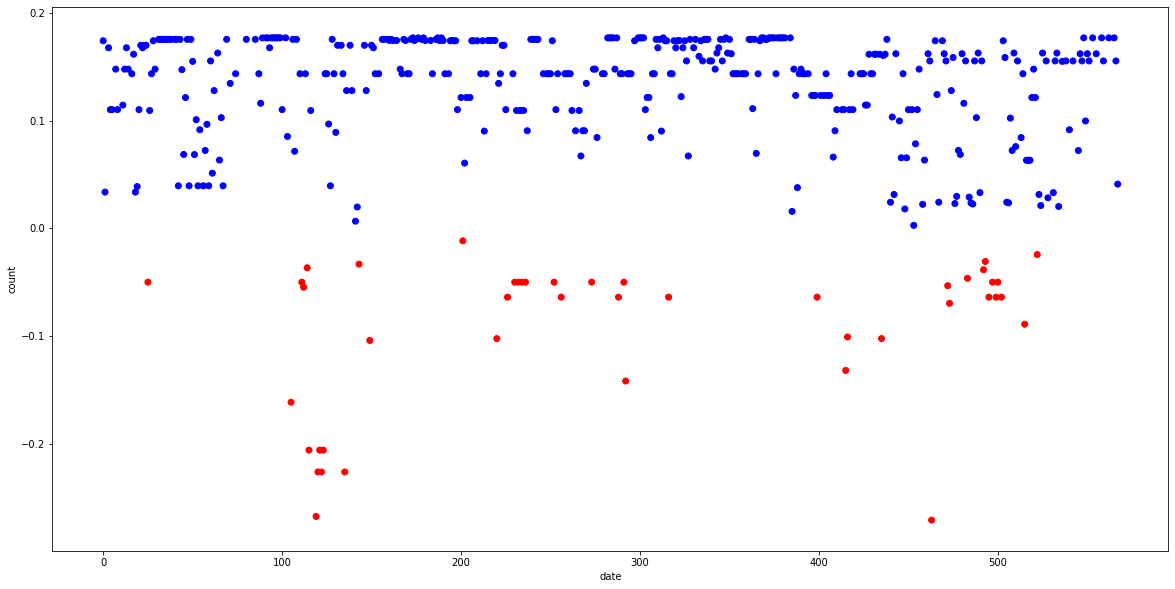

In [82]:
plt.figure(figsize=(20,10))
plt.scatter(x=X_train.index, y=X_train.scores, color=np.where(X_train['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()


In [ ]:
print('Number of predicted anomalies within the Test Set  ', list(y_pred).count(-1) )
print('')
print('Predictions ', y_pred)# -1 anomalie , 1 normal point

print('----------------------------------------')
print(' Anomalies detected from the test set predictions ')
anom = df.loc[pd.to_datetime(outlier_index)] 

#print ( anom )
print(anom['count'].value_counts())

anom

    in the following dataframe visualization,we can see that many timestamps are duplicated ,but with different features -->how to treat this ?

In [ ]:
anom[anom.index.duplicated(keep=False)]